# **IMPORT LIBS**

## Import

In [1]:
import numpy as np
from openrec.tf1.legacy import ImplicitModelTrainer
from openrec.tf1.legacy.utils.evaluators import ImplicitEvalManager
from openrec.tf1.legacy.utils import ImplicitDataset
from openrec.tf1.legacy.recommenders import CML, BPR, PMF
from openrec.tf1.legacy.utils.evaluators import AUC
from openrec.tf1.legacy.utils.samplers import PairwiseSampler
from tqdm.notebook import tqdm
import numpy as np
import math
import pandas as pd
import os
import pickle

In [2]:
REPEAT_TRAINING = False

# **GENERATE THE DATASET**

## Init

In [3]:
# Set the seed for reproducibility
seed = 2384795
np.random.seed(seed=seed)

# Preparing folder for output data
output_name = f"./generated_data/"
if os.path.exists(output_name) == False:
    os.makedirs(output_name)

## Load the dataset

In [4]:
# Name of the dataset paths
file_path = 'ydata-ymusic-rating-study-v1_0-train.txt'
folder_name = f"./original_files/"

# Load the training set into a DataFrame
df_train = pd.read_csv(folder_name+file_path, sep='\t',names=["UserID","SongID","Rating"], header=None)  # sep='\t' for tab-separated values

# Visualize
df_train.head(10)

,UserID,SongID,Rating
0,1,14,5
1,1,35,1
2,1,46,1
3,1,83,1
4,1,93,1
5,1,94,1
6,1,153,5
7,1,170,4
8,1,184,5
9,1,194,5


## Convert to implicit

"We treat items rated greater than or equal to 4 as relevant, and others as irrelevant, as suggested by prior literature."

In [5]:
# Suggested on paper
POSITIVE_THRESHOLD = 4

# Add column to the DataFrame
df_train['ImplicitRating'] = np.where(df_train['Rating'] >= POSITIVE_THRESHOLD, 1, 0)

# Visualize
df_train.head(10)

,UserID,SongID,Rating,ImplicitRating
0,1,14,5,1
1,1,35,1,0
2,1,46,1,0
3,1,83,1,0
4,1,93,1,0
5,1,94,1,0
6,1,153,5,1
7,1,170,4,1
8,1,184,5,1
9,1,194,5,1


## Check the number of users and items in the training set

"The training set contains 300K ratings given by 15.4K users against 1K songs through natural interactions."

In [6]:
# Store the range of ids for users
min_user = df_train["UserID"].min()
max_user = df_train["UserID"].max()

# Store the range of items
min_item = df_train["SongID"].min()
max_item = df_train["SongID"].max()

# Visualize the number of both
max_item, max_user

(1000, 15400)

# **GET UNBIASED TESTSET**

## Load the unbiased testset

In [7]:
# Name of the dataset path
file_path = folder_name + 'ydata-ymusic-rating-study-v1_0-test.txt'

# Load the training set into a DataFrame
df_test = pd.read_csv(file_path, sep='\t',names=["UserID","SongID","Rating"], header=None)

## Convert to implicit

In [8]:
# Add column to the DataFrame
df_test['ImplicitRating'] = np.where(df_test['Rating'] >= POSITIVE_THRESHOLD, 1, 0)

# Visualize
df_test.head(10)

,UserID,SongID,Rating,ImplicitRating
0,1,49,1,0
1,1,126,1,0
2,1,138,1,0
3,1,141,1,0
4,1,177,1,0
5,1,268,3,0
6,1,511,1,0
7,1,587,1,0
8,1,772,5,1
9,1,941,1,0


## Check the number of users and items in the training set

"The testing set is collected by asking a subset of 5.4K users to rate 10 randomly selected songs."

In [9]:
# Visualize
df_test["UserID"].max(), df_test["SongID"].max()

(5400, 1000)

## Filter unbiased testset

"We filter the testing set by retaining users who have at least a relevant and an irrelevant song in the testing set and two relevant songs in the training set."

In [10]:
# Select users with at least an irrelevant song in the unbiased testset
usersWithNegativeInteractionInTest = df_test[df_test["ImplicitRating"] == 0]["UserID"].unique()

# Select UserID of users with at least a relevant song in testset
usersWithPositiveInteractionInTest = df_test[df_test["ImplicitRating"] == 1]["UserID"].unique()

# Select UserID of users with at least two relevant song in trainset
usersWithTwoPositiveInteractions = df_train[df_train["ImplicitRating"] == 1].groupby("UserID").filter(lambda x: len(x) >= 2)['UserID'].unique()

# Compute the intersection
set1 = set(usersWithNegativeInteractionInTest)
set2 = set(usersWithPositiveInteractionInTest)
set3 = set(usersWithTwoPositiveInteractions)
valid_users_testset = set1 & set2 & set3

# Filter the testset
df_test_filtered = df_test[df_test["UserID"].isin(valid_users_testset)]

"2296 users satisfy these requirements."

In [11]:
# Visualize
len(valid_users_testset)

2296

## Shape the unbiased test set

In [12]:
# From the dataframe, for each row where ImplicitRating is 1, append [userID, itemID] to unbiased_pos_test_set
# and for each row where ImplicitRating is 0, append [userID, itemID] to unbiased_neg_test_set
unbiased_pos_test_set = df_test_filtered[df_test_filtered["ImplicitRating"] == 1][["UserID", "SongID"]].values
unbiased_neg_test_set = df_test_filtered[df_test_filtered["ImplicitRating"] == 0][["UserID", "SongID"]].values

## Save unbiased test set

In [13]:
# Remember to split pos and neg test set into two separate files

# Get the dataframe
unbiased_pos_test_set_df = pd.DataFrame(unbiased_pos_test_set)
unbiased_neg_test_set_df = pd.DataFrame(unbiased_neg_test_set)

# Get couples user-item
unbiased_pos_test_set_df.columns = ["user_id","item_id"]
unbiased_neg_test_set_df.columns = ["user_id","item_id"]

# Turn into records
structured_data_pos_test_set_unbiased = unbiased_pos_test_set_df.to_records(index=False)
structured_data_neg_test_set_unbiased = unbiased_neg_test_set_df.to_records(index=False)

# Save
np.save(output_name + "unbiased-test_arr_pos.npy", structured_data_pos_test_set_unbiased)
np.save(output_name + "unbiased-test_arr_neg.npy", structured_data_neg_test_set_unbiased)

# **GET BIASED TESTSET**

## Read again to reset

In [14]:
# Name of the dataset path
file_path = folder_name + 'ydata-ymusic-rating-study-v1_0-train.txt'

# Load the training set into a DataFrame
df_train = pd.read_csv(file_path, sep='\t',names=["UserID","SongID","Rating"], header=None)  # sep='\t' for tab-separated values
df_train['ImplicitRating'] = np.where(df_train['Rating'] >= POSITIVE_THRESHOLD, 1, 0)
df_train = df_train[df_train["UserID"].isin(valid_users_testset)]

## Extract the biased test set and shape it

"We additionally held out a biased testing set (biased-testing) from the training set by randomly sampling 300 songs for each user."

In [15]:
# Precompute, for each user, the list of songs with a relevant rating
user_positive_ratings = df_train[df_train["ImplicitRating"] == 1].groupby("UserID")["SongID"].apply(set)

# Initialize the range of indexes for the items
items_ids = np.arange(min_item, max_item + 1)

# Set the number of songs for each user
SONGS_FOR_BIASED_TEST = 300

# Init empty
pos_test_set = []
neg_test_set = []

# Extract the biased test set
for user_id in valid_users_testset:

    # Get SONGS_FOR_BIASED_TEST items
    np.random.shuffle(items_ids)
    test_items = set(items_ids[-SONGS_FOR_BIASED_TEST:])

    # Get which are positive
    pos_ids = user_positive_ratings.get(user_id, set()) & test_items

    # Set the positive ones to 0 in the training set (extract)
    df_train.loc[(df_train['SongID'].isin(pos_ids)) & (df_train['UserID'] == user_id), 'ImplicitRating'] = 0

    # Append items
    for id in test_items:
        if id in pos_ids:
            pos_test_set.append([user_id, id])
        else:
            neg_test_set.append([user_id, id])

# Get np arrays
pos_test_set = np.array(pos_test_set)
neg_test_set = np.array(neg_test_set)

## Save the biased test set

In [16]:
# Remember to split pos and neg test set into two separate files

# Get the dataframe
pos_test_set_df = pd.DataFrame(pos_test_set)
neg_test_set_df = pd.DataFrame(neg_test_set)

# Get couples user-item
pos_test_set_df.columns = ["user_id","item_id"]
neg_test_set_df.columns = ["user_id","item_id"]

# Turn into records
structured_data_pos_test_set = pos_test_set_df.to_records(index=False)
structured_data_neg_test_set = neg_test_set_df.to_records(index=False)

# Save
np.save(output_name + "biased-test_arr_pos.npy", structured_data_pos_test_set)
np.save(output_name + "biased-test_arr_neg.npy", structured_data_neg_test_set)

## **STORE TRAINSET**

## Filter positive couples (user, item)

In [17]:
# Only take the couples (user, item) with relevant rating
new_df = df_train[df_train['ImplicitRating'] != 0]
new_df = new_df.drop(columns=['Rating', 'ImplicitRating'])

# Define a dictionary for renaming columns
rename_dict = {
    'UserID': 'user_id',
    'SongID': 'item_id'
}

# Rename the columns
new_df = new_df.rename(columns=rename_dict)

# Convert the DataFrame to a structured array
train_data = new_df.to_records(index=False) 

## Save the training set

In [18]:
# Save
np.save(output_name + "training_arr.npy", train_data)

# **MODEL CHOICE**

In [19]:
# Here I won't comment anything, we are just using the code provided by the authors of the paper

raw_data = dict()
raw_data['train_data'] = np.load(output_name + "training_arr.npy")
raw_data['max_user'] = 15401
raw_data['max_item'] = 1001
batch_size = 8000
test_batch_size = 1000
display_itr = 1000

train_dataset = ImplicitDataset(raw_data['train_data'], raw_data['max_user'], raw_data['max_item'], name='Train')

MODEL_CLASS = CML
MODEL_PREFIX = "cml"
DATASET_NAME = "yahoo"
OUTPUT_FOLDER = output_name
OUTPUT_PATH = OUTPUT_FOLDER + MODEL_PREFIX + "-" + DATASET_NAME + "/"
OUTPUT_PREFIX = str(OUTPUT_PATH) + str(MODEL_PREFIX) + "-" + str(DATASET_NAME)


if os.path.exists(OUTPUT_PATH) == False:
    os.makedirs(OUTPUT_PATH)


# **TRAIN THE MODEL**

In [20]:
# Prevent tensorflow from using cached embeddings
import tensorflow as tf
tf.compat.v1.reset_default_graph()
tf.set_random_seed(seed)

In [21]:
if REPEAT_TRAINING:
    # Define the model
    model = MODEL_CLASS(batch_size=batch_size, max_user=train_dataset.max_user(), max_item=train_dataset.max_item(), dim_embed=50, l2_reg=0.001, opt='Adam', sess_config=None)
    sampler = PairwiseSampler(batch_size=batch_size, dataset=train_dataset, num_process=4)
    model_trainer = ImplicitModelTrainer(batch_size=batch_size, test_batch_size=test_batch_size, train_dataset=train_dataset, model=model, sampler=sampler, eval_save_prefix=OUTPUT_PATH + DATASET_NAME, item_serving_size=500)
    auc_evaluator = AUC()

    # Train the model
    model_trainer.train(num_itr=10001, display_itr=display_itr)

    # Save in the output folder
    model.save(OUTPUT_PATH,None)

    # Delete the model from the memory
    del model

# **DEFINING FUNCTIONS**

In [22]:
def calculate_propensities(n_users, n_items, trainfilename, gammas=[1.5, 2, 2.5, 3], normalize=True):

    propensities = dict()
    Ni = dict()
    
    # Compute frequencies of items in the training set
    trainset = np.load(trainfilename)
    for i in trainset['item_id']:
        if i in Ni:
            Ni[i] += 1
        else:
            Ni[i] = 1
    del trainset

    for gamma in gammas:
        propensities[gamma] = np.zeros((n_users,n_items))

  
    for theitem in range(n_items):
        if theitem not in Ni:
            continue
        for gamma in gammas:
            propensities[gamma][:,theitem] =  np.power(Ni[theitem], (gamma + 1) / 2.0)

    if normalize:
        for gamma in gammas:
            propensities[gamma] /= propensities[gamma].max()

    return propensities

In [23]:
def eq(infilename, infilename_neg, trainfilename, propensities, K=1):

    # Read pickles
    infile = open(infilename, 'rb')
    infile_neg = open(infilename_neg, 'rb')
    P = pickle.load(infile)
    infile.close()
    P_neg = pickle.load(infile_neg)
    infile_neg.close()
    NUM_NEGATIVES = P["num_negatives"]
    
    # Merge P and P_neg
    for theuser in P["users"]:
        neg_items = list(P_neg["user_items"][theuser][NUM_NEGATIVES:])
        neg_scores = list(P_neg["results"][theuser][NUM_NEGATIVES:])
        P["user_items"][theuser] = list(neg_items) + list(P["user_items"][theuser][NUM_NEGATIVES:])
        P["results"][theuser] = list(neg_scores) + list(P["results"][theuser][NUM_NEGATIVES:])
    
    Zui = dict()
    Ni = dict()
    
    # Compute frequencies of items in the training set
    trainset = np.load(trainfilename)
    for i in trainset['item_id']:
        if i in Ni:
            Ni[i] += 1
        else:
            Ni[i] = 1
    del trainset

    # Count #users with non-zero item frequencies
    nonzero_user_count = 0
    for theuser in P["users"]:
        pos_items = P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]
        for pos_item in pos_items:
            if pos_item in Ni:
                nonzero_user_count += 1
                break
    
    # Compute recommendations for each user
    for theuser in P["users"]:
        all_scores = np.array(P["results"][theuser])
        pos_items = P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]
        pos_scores = P["results"][theuser][len(P_neg["results"][theuser][NUM_NEGATIVES:]):]
        for i, pos_item in enumerate(pos_items):
            pos_score = pos_scores[i]
            Zui[(theuser, pos_item)] = float(np.sum(all_scores > pos_score))

    
    # Calculate per-user scores
    sum_user_auc = 0.0
    sum_user_recall = 0.0
    for theuser in P["users"]:
        numerator_auc = 0.0
        numerator_recall = 0.0
        denominator = 0.0

        for theitem in P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]:
            # Skip items with null frequency
            if theitem not in Ni:
                continue
            
            # Load propensity score
            pui = propensities[theuser][theitem]

            # Add things to be summed for each item
            numerator_auc += (1 - Zui[(theuser, theitem)] / len(P["user_items"][theuser])) / pui

            # Add things for recall
            if Zui[(theuser, theitem)] < K:
                numerator_recall += 1.0 / pui

            # Increment denominator that the sum must be divided by
            denominator += 1 / pui
                
        # If there was at least one item for the user, count the user and sum the results
        if denominator > 0:
            sum_user_auc += numerator_auc / denominator
            sum_user_recall += numerator_recall / denominator 

    # Return
    return {
        "auc"       : sum_user_auc / nonzero_user_count,
        "recall"    : sum_user_recall / nonzero_user_count,
        "bias"      : -1,
        "concentration" : -1
    }

In [24]:
def aoa(infilename, infilename_neg, trainfilename, K=1):

    # Read pickles
    infile = open(infilename, 'rb')
    infile_neg = open(infilename_neg, 'rb')
    P = pickle.load(infile)
    infile.close()
    P_neg = pickle.load(infile_neg)
    infile_neg.close()
    NUM_NEGATIVES = P["num_negatives"]
    
    # Merge P and P_neg
    for theuser in P["users"]:
        neg_items = list(P_neg["user_items"][theuser][NUM_NEGATIVES:])
        neg_scores = list(P_neg["results"][theuser][NUM_NEGATIVES:])
        P["user_items"][theuser] = list(neg_items) + list(P["user_items"][theuser][NUM_NEGATIVES:])
        P["results"][theuser] = list(neg_scores) + list(P["results"][theuser][NUM_NEGATIVES:])
    
    Zui = dict()
    Ni = dict()

    # Compute frequencies of items in the training set
    trainset = np.load(trainfilename)
    for i in trainset['item_id']:
        if i in Ni:
            Ni[i] += 1
        else:
            Ni[i] = 1
    del trainset
    
    # Count #users with non-zero item frequencies
    nonzero_user_count = 0
    for theuser in P["users"]:
        pos_items = P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]
        for pos_item in pos_items:
            if pos_item in Ni:
                nonzero_user_count += 1
                break
    
    # Compute recommendations for each user
    for theuser in P["users"]:
        all_scores = np.array(P["results"][theuser])
        pos_items = P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]
        pos_scores = P["results"][theuser][len(P_neg["results"][theuser][NUM_NEGATIVES:]):]
        for i, pos_item in enumerate(pos_items):
            pos_score = pos_scores[i]
            Zui[(theuser, pos_item)] = float(np.sum(all_scores > pos_score))

    # Calculate per-user scores
    sum_user_auc = 0.0
    sum_user_recall = 0.0
    for theuser in P["users"]:
        numerator_auc = 0.0
        numerator_recall = 0.0
        denominator = 0.0

        for theitem in P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]:
            # Skip items with null frequency
            if theitem not in Ni:
                continue

            # Add things to be summed for each item
            numerator_auc += (1 - Zui[(theuser, theitem)] / len(P["user_items"][theuser]))

            # Add things for recall
            if Zui[(theuser, theitem)] < K:
                numerator_recall += 1.0
                
            # Increment denominator that the sum must be divided by
            denominator += 1 

        # If there was at least one item for the user, count the user and sum the results
        if denominator > 0:
            sum_user_auc += numerator_auc / denominator
            sum_user_recall += numerator_recall / denominator

    # Return
    return {
        "auc"       : sum_user_auc / nonzero_user_count,
        "recall"    : sum_user_recall / nonzero_user_count,
        "bias"      : -1,
        "concentration" : -1
    }

In [25]:
def stratified(infilename, infilename_neg, trainfilename, propensities, K=30, partition=10, delta=0.1):

    # Read pickles
    infile = open(infilename, 'rb')
    infile_neg = open(infilename_neg, 'rb')
    P = pickle.load(infile)
    infile.close()
    P_neg = pickle.load(infile_neg)
    infile_neg.close()
    NUM_NEGATIVES = P["num_negatives"]

    # Merge P and P_neg
    for theuser in P["users"]:
        neg_items = list(P_neg["user_items"][theuser][NUM_NEGATIVES:])
        neg_scores = list(P_neg["results"][theuser][NUM_NEGATIVES:])
        P["user_items"][theuser] = list(neg_items) + list(P["user_items"][theuser][NUM_NEGATIVES:])
        P["results"][theuser] = list(neg_scores) + list(P["results"][theuser][NUM_NEGATIVES:])

    Zui = dict()
    Ni = dict()

    # Compute frequencies of items in the training set
    trainset = np.load(trainfilename)
    for i in trainset['item_id']:
        if i in Ni:
            Ni[i] += 1
        else:
            Ni[i] = 1
    #del trainset

    # Compute recommendations for each user
    for theuser in P["users"]:
        all_scores = np.array(P["results"][theuser])
        pos_items = P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]
        pos_scores = P["results"][theuser][len(P_neg["results"][theuser][NUM_NEGATIVES:]):]
        for i, pos_item in enumerate(pos_items):
            pos_score = pos_scores[i]
            Zui[(theuser, pos_item)] = float(np.sum(all_scores > pos_score))

    w = dict()

    # Store the ids of the items to be used to compute the bias
    items_of_the_test_set = set()
    for theuser in P["users"]:
        for theitem in P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]:
            if theitem not in items_of_the_test_set:
                items_of_the_test_set.add(theitem)

   
    # Using as pui a single row of propensities, as we assumed propensities to be user independent
    pui = propensities[0,:]

    # Take the list of items (not tuples) in pui sorted by value
    items_sorted_by_value = np.argsort(pui)[::-1]

    # Remove items not of the testset
    items_sorted_by_value = np.array([item for item in items_sorted_by_value if item in items_of_the_test_set])

    # Filter out indices of the items not in the test set
    items_sorted_by_value = items_sorted_by_value[pui[items_sorted_by_value] > 0]

    # Compute linspace between the pui[0] and pui[-1] 
    linspace = np.linspace(pui[items_sorted_by_value[0]], pui[items_sorted_by_value[-1]], partition+1)
   
    # Compute dictionary w, that is, for each item, assigns the average of the puis in the partition it belongs to
    i=0
    j = 0
    while i < len(items_sorted_by_value):
                            
        avg = 0
        start = i
        end = i
    
        while i < len(items_sorted_by_value) and pui[items_sorted_by_value[i]] >= linspace[j+1]:
            avg += 1.0 / pui[items_sorted_by_value[i]]
            end = i
            i += 1
        avg = avg / (end - start + 1)

        for k in range(start, end+1):
            w[items_sorted_by_value[k]] = avg

        j += 1

    # Compute bias' numerator
    bias = 0.0
    for k in items_sorted_by_value:
        # add |pui*w - 1!|
        bias += abs(pui[k] * w[k] - 1)
    # Multiply by number of users
    bias *= len(P["users"])

    # Compute concentrations numerator (for each user)
    concentrations = {}
    max_w = max(w.values())
    # ... by computing the sum of squares of w for each user
    for user, item in zip(trainset['user_id'], trainset['item_id']):
        # Iterate over the trainset to compute the sum of squares for each user
        if item in w:
            if user not in concentrations:
                concentrations[user] = 0
            concentrations[user] += w[item] ** 2
    # ... and then applying the formula
    for user in concentrations:
        concentrations[user] = math.sqrt(concentrations[user] * 2 * math.log(2/delta)) + max_w * 7 * math.log(2/delta)
    # Now sum all the concentrations
    concentration = sum(concentrations.values())

    # Calculate per-user scores
    nonzero_user_count = 0
    sum_user_auc = 0.0
    sum_user_recall = 0.0
    for theuser in P["users"]:
        numerator_auc = 0.0
        numerator_recall = 0.0
        denominator = 0.0
        
        for theitem in P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]:
            # Skip items with null frequency
            if  theitem not in Ni:
                continue

            # Add things to be summed for each item
            numerator_auc += (1 - Zui[(theuser, theitem)] / len(P["user_items"][theuser])) * w[theitem]

            # Add things for recall
            if Zui[(theuser, theitem)] < K:
                numerator_recall += 1.0 * w[theitem]

            # Increment denominator that the sum must be divided by 
            denominator += 1 / pui[theitem]

        # If there was at least one item for the user, count the user and sum the results
        if denominator > 0:
            nonzero_user_count += 1
            sum_user_auc += numerator_auc / denominator
            sum_user_recall += numerator_recall / denominator 

    # Return
    return {
        "auc"       : sum_user_auc / nonzero_user_count, 
        "recall"    : sum_user_recall / nonzero_user_count,
        "bias"      : bias,
        "concentration" : concentration
    }

In [26]:
def stratified_logspace(infilename, infilename_neg, trainfilename, propensities, K=30, partition=10, delta=0.1):

    # Read pickles
    infile = open(infilename, 'rb')
    infile_neg = open(infilename_neg, 'rb')
    P = pickle.load(infile)
    infile.close()
    P_neg = pickle.load(infile_neg)
    infile_neg.close()
    NUM_NEGATIVES = P["num_negatives"]

    # Merge P and P_neg
    for theuser in P["users"]:
        neg_items = list(P_neg["user_items"][theuser][NUM_NEGATIVES:])
        neg_scores = list(P_neg["results"][theuser][NUM_NEGATIVES:])
        P["user_items"][theuser] = list(neg_items) + list(P["user_items"][theuser][NUM_NEGATIVES:])
        P["results"][theuser] = list(neg_scores) + list(P["results"][theuser][NUM_NEGATIVES:])

    Zui = dict()
    Ni = dict()

    # Compute frequencies of items in the training set
    trainset = np.load(trainfilename)
    for i in trainset['item_id']:
        if i in Ni:
            Ni[i] += 1
        else:
            Ni[i] = 1
    #del trainset

    # Compute recommendations for each user
    for theuser in P["users"]:
        all_scores = np.array(P["results"][theuser])
        pos_items = P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]
        pos_scores = P["results"][theuser][len(P_neg["results"][theuser][NUM_NEGATIVES:]):]
        for i, pos_item in enumerate(pos_items):
            pos_score = pos_scores[i]
            Zui[(theuser, pos_item)] = float(np.sum(all_scores > pos_score))

    w = dict()

    # Store the ids of the items to be used to compute the bias
    items_of_the_test_set = set()
    for theuser in P["users"]:
        for theitem in P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]:
            if theitem not in items_of_the_test_set:
                items_of_the_test_set.add(theitem)

   
    # Using as pui a single row of propensities, as we assumed propensities to be user independent
    pui = propensities[0,:]

    # Take the list of items (not tuples) in pui sorted by value
    items_sorted_by_value = np.argsort(pui)[::-1]

    # Remove items not of the testset
    items_sorted_by_value = np.array([item for item in items_sorted_by_value if item in items_of_the_test_set])

    # Filter out indices of the items not in the test set
    items_sorted_by_value = items_sorted_by_value[pui[items_sorted_by_value] > 0]

    # Maybe try to split the logspace instead of the linspace?
    logspace = np.logspace(pui[items_sorted_by_value[0]], pui[items_sorted_by_value[-1]], partition+1)
   
    # Compute dictionary w, that is, for each item, assigns the average of the puis in the partition it belongs to
    i=0
    j = 0
    while i < len(items_sorted_by_value):
                            
        avg = 0
        start = i
        end = i
    
        while i < len(items_sorted_by_value) and pui[items_sorted_by_value[i]] >= logspace[j+1]:
            avg += 1.0 / pui[items_sorted_by_value[i]]
            end = i
            i += 1
        
        # Is the average the only good choice? even with the log space split?
        avg = avg / (end - start + 1)

        for k in range(start, end+1):
            w[items_sorted_by_value[k]] = avg

        j += 1

        # Compute bias' numerator
        bias = 0.0
        for k in items_sorted_by_value:
            # add |pui*w - 1!|
            bias += abs(pui[k] * w[k] - 1)
        # Multiply by number of users
        bias *= len(P["users"])

        # Compute concentrations numerator (for each user)
        concentrations = {}
        max_w = max(w.values())
        # ... by computing the sum of squares of w for each user
        for user, item in zip(trainset['user_id'], trainset['item_id']):
            # Iterate over the trainset to compute the sum of squares for each user
            if item in w:
                if user not in concentrations:
                    concentrations[user] = 0
                concentrations[user] += w[item] ** 2
        # ... and then applying the formula
        for user in concentrations:
            concentrations[user] = math.sqrt(concentrations[user] * 2 * math.log(2/delta)) + max_w * 7 * math.log(2/delta)
        # Now sum all the concentrations
        concentration = sum(concentrations.values())

    # Calculate per-user scores
    nonzero_user_count = 0
    sum_user_auc = 0.0
    sum_user_recall = 0.0
    for theuser in P["users"]:
        numerator_auc = 0.0
        numerator_recall = 0.0
        denominator = 0.0
        
        for theitem in P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]:
            # Skip items with null frequency
            if  theitem not in Ni:
                continue

            # Add things to be summed for each item
            numerator_auc += (1 - Zui[(theuser, theitem)] / len(P["user_items"][theuser])) * w[theitem]

            # Add things for recall
            if Zui[(theuser, theitem)] < K:
                numerator_recall += 1.0 * w[theitem]

            # Increment denominator that the sum must be divided by 
            denominator += 1 / pui[theitem]

        # If there was at least one item for the user, count the user and sum the results
        if denominator > 0:
            nonzero_user_count += 1
            sum_user_auc += numerator_auc / denominator
            sum_user_recall += numerator_recall / denominator  

    # Return
    return {
        "auc"       : sum_user_auc / nonzero_user_count, 
        "recall"    : sum_user_recall / nonzero_user_count,
        "bias"      : bias,
        "concentration" : concentration
    }

In [27]:
# This version uses the linspace of the number of number of items used for evaluation, not of the propensities
def stratified_2(infilename, infilename_neg, trainfilename, propensities, K=30, partition=10, delta=0.1):

    # Read pickles
    infile = open(infilename, 'rb')
    infile_neg = open(infilename_neg, 'rb')
    P = pickle.load(infile)
    infile.close()
    P_neg = pickle.load(infile_neg)
    infile_neg.close()
    NUM_NEGATIVES = P["num_negatives"]

    # Merge P and P_neg
    for theuser in P["users"]:
        neg_items = list(P_neg["user_items"][theuser][NUM_NEGATIVES:])
        neg_scores = list(P_neg["results"][theuser][NUM_NEGATIVES:])
        P["user_items"][theuser] = list(neg_items) + list(P["user_items"][theuser][NUM_NEGATIVES:])
        P["results"][theuser] = list(neg_scores) + list(P["results"][theuser][NUM_NEGATIVES:])

    Zui = dict()
    Ni = dict()

    # Compute frequencies of items in the training set
    trainset = np.load(trainfilename)
    for i in trainset['item_id']:
        if i in Ni:
            Ni[i] += 1
        else:
            Ni[i] = 1
    #del trainset

    # Compute recommendations for each user
    for theuser in P["users"]:
        all_scores = np.array(P["results"][theuser])
        pos_items = P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]
        pos_scores = P["results"][theuser][len(P_neg["results"][theuser][NUM_NEGATIVES:]):]
        for i, pos_item in enumerate(pos_items):
            pos_score = pos_scores[i]
            Zui[(theuser, pos_item)] = float(np.sum(all_scores > pos_score))

    w = dict()

    # Store the ids of the items to be used to compute the bias
    items_of_the_test_set = set()
    for theuser in P["users"]:
        for theitem in P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]:
            if theitem not in items_of_the_test_set:
                items_of_the_test_set.add(theitem)

   
    # Using as pui a single row of propensities, as we assumed propensities to be user independent
    pui = propensities[0,:]

    # Take the list of items (not tuples) in pui sorted by value
    items_sorted_by_value = np.argsort(pui)[::-1]

    # Remove items not of the testset
    items_sorted_by_value = np.array([item for item in items_sorted_by_value if item in items_of_the_test_set])

    # Filter out indices of the items not in the test set
    items_sorted_by_value = items_sorted_by_value[pui[items_sorted_by_value] > 0]

    # Compute linspace between the 0 to len(item_sorted...)
    linspace = np.linspace(0, len(items_sorted_by_value), partition+1)
   
    # Compute dictionary w, that is, for each item, assigns the average of the puis in the partition it belongs to
    i=0
    j = 0
    while i < len(items_sorted_by_value):
                            
        avg = 0
        start = i
        end = i
    
        while i < len(items_sorted_by_value) and i < linspace[j+1]:
            avg += 1.0 / pui[items_sorted_by_value[i]]
            end = i
            i += 1
        
        avg = avg / (end - start + 1)

        for k in range(start, end+1):
            w[items_sorted_by_value[k]] = avg

        j += 1

    # Compute bias' numerator
    bias = 0.0
    for k in items_sorted_by_value:
        # add |pui*w - 1!|
        bias += abs(pui[k] * w[k] - 1)
    # Multiply by number of users
    bias *= len(P["users"])

    # Compute concentrations numerator (for each user)
    concentrations = {}
    max_w = max(w.values())
    # ... by computing the sum of squares of w for each user
    for user, item in zip(trainset['user_id'], trainset['item_id']):
        # Iterate over the trainset to compute the sum of squares for each user
        if item in w:
            if user not in concentrations:
                concentrations[user] = 0
            concentrations[user] += w[item] ** 2
    # ... and then applying the formula
    for user in concentrations:
        concentrations[user] = math.sqrt(concentrations[user] * 2 * math.log(2/delta)) + max_w * 7 * math.log(2/delta)
    # Now sum all the concentrations
    concentration = sum(concentrations.values())

    # Calculate per-user scores
    nonzero_user_count = 0
    sum_user_auc = 0.0
    sum_user_recall = 0.0
    for theuser in P["users"]:
        numerator_auc = 0.0
        numerator_recall = 0.0
        denominator = 0.0
        
        for theitem in P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]:
            # Skip items with null frequency
            if  theitem not in Ni:
                continue

            # Add things to be summed for each item
            numerator_auc += (1 - Zui[(theuser, theitem)] / len(P["user_items"][theuser])) * w[theitem]

            # Add things for recall
            if Zui[(theuser, theitem)] < K:
                numerator_recall += 1.0 * w[theitem]

            # Increment denominator that the sum must be divided by 
            denominator += 1 / pui[theitem]

        # If there was at least one item for the user, count the user and sum the results
        if denominator > 0:
            nonzero_user_count += 1
            sum_user_auc += numerator_auc / denominator
            sum_user_recall += numerator_recall / denominator 

    # Return
    return {
        "auc"       : sum_user_auc / nonzero_user_count, 
        "recall"    : sum_user_recall / nonzero_user_count,
        "bias"      : bias,
        "concentration" : concentration
    }

# **EVALUATION**

In [28]:
GAMMAS = [1.5,2,2.5,3]

In [29]:
# Load data
raw_data = dict()
raw_data['train_data'] = np.load(output_name + "training_arr.npy")
raw_data['test_data_pos_biased'] = np.load(output_name + "biased-test_arr_pos.npy")
raw_data['test_data_neg_biased'] = np.load(output_name + "biased-test_arr_neg.npy")
raw_data['test_data_pos_unbiased'] = np.load(output_name + "unbiased-test_arr_pos.npy")
raw_data['test_data_neg_unbiased'] = np.load(output_name + "unbiased-test_arr_neg.npy")
raw_data['max_user'] = 15401
raw_data['max_item'] = 1001
batch_size = 8000
test_batch_size = 1000
display_itr = 1000

# Load data
train_dataset = ImplicitDataset(raw_data['train_data'], raw_data['max_user'], raw_data['max_item'], name='Train')
test_dataset_pos_biased = ImplicitDataset(raw_data['test_data_pos_biased'], raw_data['max_user'], raw_data['max_item'])
test_dataset_neg_biased = ImplicitDataset(raw_data['test_data_neg_biased'], raw_data['max_user'], raw_data['max_item'])
test_dataset_pos_unbiased = ImplicitDataset(raw_data['test_data_pos_unbiased'], raw_data['max_user'], raw_data['max_item'])
test_dataset_neg_unbiased = ImplicitDataset(raw_data['test_data_neg_unbiased'], raw_data['max_user'], raw_data['max_item'])

In [30]:
tf.compat.v1.reset_default_graph()

In [31]:
# Define the model
model = MODEL_CLASS(batch_size=batch_size, max_user=train_dataset.max_user(), max_item=train_dataset.max_item(), dim_embed=50, l2_reg=0.001, opt='Adam', sess_config=None)
sampler = PairwiseSampler(batch_size=batch_size, dataset=train_dataset, num_process=4)
model_trainer = ImplicitModelTrainer(batch_size=batch_size, test_batch_size=test_batch_size, train_dataset=train_dataset, model=model, sampler=sampler, eval_save_prefix=OUTPUT_PATH + DATASET_NAME, item_serving_size=500)
auc_evaluator = AUC()

# Load model
model.load(OUTPUT_PATH)

# Set parameters
model_trainer._eval_manager = ImplicitEvalManager(evaluators=[auc_evaluator])
model_trainer._num_negatives = 200
model_trainer._exclude_positives([train_dataset, test_dataset_pos_biased, test_dataset_neg_biased])
model_trainer._sample_negatives(seed=10)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






2024-08-20 14:38:45.341237: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-08-20 14:38:45.344760: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 4192055000 Hz
2024-08-20 14:38:45.345364: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c1cb36ee50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-08-20 14:38:45.345381: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


INFO:tensorflow:Restoring parameters from ./generated_data/cml-yahoo/
[Subsampling negative items]


## Biased Evaluation

In [32]:
model_trainer._eval_save_prefix = OUTPUT_PREFIX + "-test-pos-biased"
model_trainer._evaluate_partial(test_dataset_pos_biased)

model_trainer._eval_save_prefix = OUTPUT_PREFIX +  "-test-neg-biased"
model_trainer._evaluate_partial(test_dataset_neg_biased)

100%|██████████| 2296/2296 [00:25<00:00, 90.02it/s]


{'AUC': [0.5039491525423728,
  0.5153220338983051,
  0.5071644295302014,
  0.5041442953020134,
  0.4916666666666667,
  0.4769661016949153,
  0.5358892617449664,
  0.5279222972972972,
  0.5011577181208055,
  0.4937878787878789,
  0.517864406779661,
  0.5050675675675675,
  0.4627638190954774,
  0.4978,
  0.5228472222222221,
  0.4881879194630873,
  0.5278595317725752,
  0.48707482993197276,
  0.5023322147651007,
  0.5379797979797981,
  0.5238127090301004,
  0.5319349315068492,
  0.486571906354515,
  0.4471644295302013,
  0.4835451505016722,
  0.4724295774647888,
  0.49429553264604814,
  0.48894648829431436,
  0.4587074829931973,
  0.5340909090909091,
  0.4631711409395972,
  0.5076094276094276,
  0.47067708333333336,
  0.5034782608695653,
  0.47471476510067107,
  0.49164429530201337,
  0.5371070234113712,
  0.46685374149659864,
  0.4741442953020134,
  0.5084966216216217,
  0.5023986486486486,
  0.43272413793103454,
  0.552098976109215,
  0.47006734006734013,
  0.4715604026845638,
  0.49927

## Unbiased Evaluation

In [33]:
model_trainer._eval_save_prefix = OUTPUT_PREFIX + "-test-pos-unbiased"
model_trainer._evaluate_partial(test_dataset_pos_unbiased)

model_trainer._eval_save_prefix = OUTPUT_PREFIX +  "-test-neg-unbiased"
model_trainer._evaluate_partial(test_dataset_neg_unbiased)

100%|██████████| 2296/2296 [00:01<00:00, 1528.65it/s]


{'AUC': [0.46611111111111103,
  0.5780000000000001,
  0.5166666666666666,
  0.5066666666666667,
  0.49222222222222217,
  0.4635714285714285,
  0.38833333333333336,
  0.5835714285714285,
  0.454375,
  0.46444444444444444,
  0.369375,
  0.43357142857142855,
  0.5721428571428572,
  0.45875,
  0.465,
  0.5116666666666667,
  0.47388888888888886,
  0.5149999999999999,
  0.4992857142857144,
  0.5127777777777778,
  0.493125,
  0.47,
  0.32944444444444443,
  0.45,
  0.675,
  0.33062499999999995,
  0.79,
  0.490625,
  0.393125,
  0.5744444444444443,
  0.19714285714285712,
  0.5222222222222223,
  0.46499999999999997,
  0.49833333333333335,
  0.4600000000000001,
  0.692857142857143,
  0.6625,
  0.3825,
  0.51,
  0.40785714285714286,
  0.5125,
  0.480625,
  0.62125,
  0.506,
  0.41444444444444445,
  0.50375,
  0.49000000000000005,
  0.2225,
  0.4888888888888888,
  0.4677777777777778,
  0.5438888888888889,
  0.5429999999999999,
  0.4666666666666666,
  0.39888888888888885,
  0.41333333333333333,
  0.

## Calculate Propensities

In [49]:
propensities = calculate_propensities(15401,1001, output_name+"training_arr.npy",normalize=True)

In [50]:
propensities

{1.5: array([[0.        , 0.29915924, 0.00843328, ..., 0.05913756, 0.01114638,
         0.01399943],
        [0.        , 0.29915924, 0.00843328, ..., 0.05913756, 0.01114638,
         0.01399943],
        [0.        , 0.29915924, 0.00843328, ..., 0.05913756, 0.01114638,
         0.01399943],
        ...,
        [0.        , 0.29915924, 0.00843328, ..., 0.05913756, 0.01114638,
         0.01399943],
        [0.        , 0.29915924, 0.00843328, ..., 0.05913756, 0.01114638,
         0.01399943],
        [0.        , 0.29915924, 0.00843328, ..., 0.05913756, 0.01114638,
         0.01399943]]),
 2: array([[0.        , 0.23500814, 0.00324486, ..., 0.03359202, 0.00453483,
         0.00596118],
        [0.        , 0.23500814, 0.00324486, ..., 0.03359202, 0.00453483,
         0.00596118],
        [0.        , 0.23500814, 0.00324486, ..., 0.03359202, 0.00453483,
         0.00596118],
        ...,
        [0.        , 0.23500814, 0.00324486, ..., 0.03359202, 0.00453483,
         0.00596118],
    

## Calculate Metrics

Compute AOA and unbiased evaluator metrics with biased testset.

In [51]:
biased_results = dict()

biased_results["AOA"] = aoa(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", K=30)

for gamma in GAMMAS:
    key = "UB_" + str(gamma).replace(".","")
    biased_results[key] = eq(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=30)

Compute AOA and unbiased evaluator metrics with unbiased testset.

In [52]:
unbiased_results = dict()

# unbiased_results["STRATIFIED_15"] = stratified(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=1.5, K=4, partition=100)
unbiased_results["AOA"] = aoa(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", K=1)
for gamma in GAMMAS:
    key = "UB_" + str(gamma).replace(".","")
    unbiased_results[key] = eq(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=1)

Get partitions.

In [53]:
# Get number of items
num_items = max_item

# Get the n_p partitions
n_p = 300
nums = np.arange(1, num_items+1)
partitions = np.random.choice(nums, n_p, replace=False)

# Visualize
partitions

array([240, 200, 743, 255, 657, 469, 808, 987, 568, 323,  69, 297, 647,
       321, 352, 468, 455, 301, 359,  31, 969, 141, 803, 429, 903, 587,
       128, 167,  71, 400, 378, 992, 144, 211, 800, 601, 608, 266, 941,
       978, 327, 476, 232, 344, 258,  22, 801, 733, 696, 399, 388, 942,
       946,  48, 124, 805, 100,  80,  15, 536, 404, 473, 521, 190, 736,
        68, 363, 975, 626, 444, 692, 470, 826, 889, 847, 874, 483, 679,
       302, 879, 244, 155, 210, 667, 174, 791, 933, 463, 988, 430, 305,
       356, 514, 613, 607, 170,  55,  92, 782, 872, 558, 411, 495, 542,
       490, 519, 387, 780, 422, 417, 753, 650, 768, 456, 900, 699, 453,
       254, 382, 637, 390, 117, 685, 389, 802, 635,  34, 319, 783, 376,
       734, 126, 575, 840, 775, 415, 620, 662,  11, 677, 219, 237, 764,
       147, 569, 907, 932, 998, 909, 922, 492, 394, 668, 643, 578,  62,
       711, 973, 482,  24, 206, 156, 749, 956, 994, 809, 518, 621,  46,
       459, 143, 663, 947, 113,  57,  41, 794, 745, 163, 101, 65

Compute the partition which minimizes the sum of AUC and Recall

In [62]:
# Compute biased and unbiased results with stratified for each partition
# and store biased and unbiased results such that the sum of AUC and Recall is minimized

# Value of gamma to use for minimization
gamma = 1.5

# To print :)
key = "STRATIFIED_" + str(gamma).replace(".","")
print(key)

unbiased_results[key] = {}
biased_results[key] = {}
best_partition = np.random.choice(nums, 1)[0]
best_score = float('inf')

history = np.full(1000, np.inf)  # Adjusted to match the size of nums

for p in tqdm(partitions):
    # Fetch stratified results; these functions need to be defined or replaced with actual logic
    temp_unbiased = stratified(OUTPUT_PREFIX + "-test-pos-unbiased_evaluate_partial.pickle",
                               OUTPUT_PREFIX + "-test-neg-unbiased_evaluate_partial.pickle",
                               output_name + "training_arr.npy", propensities[gamma], K=1, partition=p)
    temp_biased = stratified(OUTPUT_PREFIX + "-test-pos-biased_evaluate_partial.pickle",
                             OUTPUT_PREFIX + "-test-neg-biased_evaluate_partial.pickle",
                             output_name + "training_arr.npy", propensities[gamma], K=30, partition=p)

    # Calculate combined score
    combined_score = temp_unbiased['bias'] + temp_unbiased['concentration'] + \
                     temp_biased['bias'] + temp_biased['concentration']

    history[p-1] = combined_score  # Store the combined score

    # Update the best_partition and best_score if the current partition's score is lower
    if combined_score < best_score:
        best_score = combined_score
        best_partition = p

print(f"Best partition: {best_partition} with combined score: {best_score}")
print(f"Minimum score from history: {np.min(history)}")


STRATIFIED_15


  0%|          | 0/300 [00:00<?, ?it/s]

Best partition: 28 with combined score: 24855822.141171552
Minimum score from history: 24855822.141171552


In [63]:
# Additional outputs for verification
print("Detailed scores from history:", history)

Detailed scores from history: [              inf               inf               inf               inf
 28389304.45856429               inf               inf               inf
 27260497.93998905               inf 26372049.44067401 26224500.79289838
               inf               inf 25698084.38735908               inf
               inf               inf               inf 25110612.4680917
               inf 24930641.53299935               inf 24901089.51418758
               inf               inf               inf 24855822.14117155
               inf               inf 24941183.23207924               inf
               inf 24953716.55908788               inf               inf
               inf               inf               inf               inf
 25215895.65230725               inf               inf               inf
               inf 25740810.14904466               inf 26084093.23593797
               inf               inf               inf               inf
               inf    

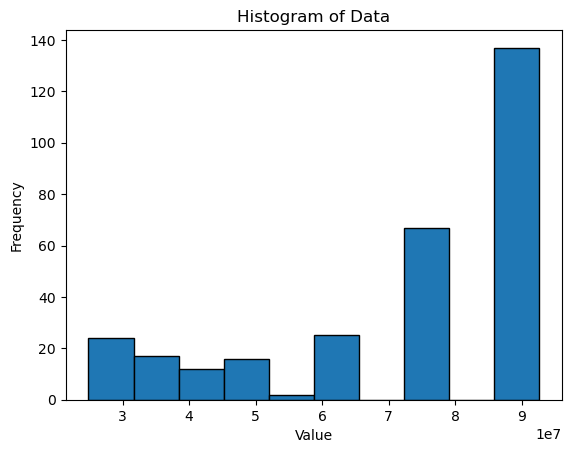

In [64]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(history[history != np.inf], bins=10, edgecolor='black')

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Display the plot
plt.show()

So, for the chosen value of gamma, the best partition is...

In [65]:
# Visualize
best_partition

28

Compute stratified metrics with unbiased testset.

In [66]:
for gamma in GAMMAS:
    key = "STRATIFIED_" + str(gamma).replace(".","")
    unbiased_results[key] = stratified(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=1, partition=best_partition)
    biased_results[key] = stratified(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=30, partition=best_partition)

This version uses the linspace of items instead of linspace of propensities to make the partition.

In [67]:
for gamma in GAMMAS:
    key = "STRATIFIED_v2_" + str(gamma).replace(".","")
    unbiased_results[key] = stratified_2(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=1, partition=best_partition)
    biased_results[key] = stratified_2(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=30, partition=best_partition)


Prepare table for results.

In [68]:
rows = 0
columns = len(biased_results.keys())

for key in biased_results.keys():
    rows = max(rows, len(biased_results[key].keys()))

for key in unbiased_results.keys():
    rows = max(rows, len(biased_results[key].keys()))

rows, columns

(4, 13)

In [69]:
# Init dictionary
mae_results = dict()

# Get the names of the rows
list_biased_res = list(biased_results.keys())

# Init results
results_array = np.zeros((rows,columns))

In [70]:
# For each row
for i in range(len(list_biased_res)):
    key = list_biased_res[i]

    # For each column
    for j in range(len(list(biased_results[key].keys()))):
        key_2 = list(biased_results[key].keys())[j]

        # Compute MAE
        results_array[j][i] = abs(biased_results[key][key_2] - unbiased_results[key][key_2])

# Make it a DataFrame
mae_df = pd.DataFrame(columns=list(biased_results.keys()), data=results_array)
metric_values = list(biased_results[list(biased_results.keys())[0]].keys())
mae_df.insert(0, "metric", metric_values)

Fill the table with the MAE results.

# **RESULTS**

In [71]:
# Visualize
mae_df.head()

,metric,AOA,UB_15,UB_2,UB_25,UB_3,STRATIFIED_15,STRATIFIED_2,STRATIFIED_25,STRATIFIED_3,STRATIFIED_v2_15,STRATIFIED_v2_2,STRATIFIED_v2_25,STRATIFIED_v2_3
0,auc,0.154493,0.128429,0.125081,0.122529,0.120581,6.079207e-02,1.036950e-01,4.504004e-01,2.416001e+00,1.673795e-01,1.727882e-01,1.810619e-01,1.925789e-01
1,recall,0.377779,0.259048,0.247508,0.238948,0.232533,3.615133e-01,6.554661e-01,1.696810e+00,5.918754e+00,3.040895e-01,3.034154e-01,3.081898e-01,3.182208e-01
2,bias,0.000000,0.000000,0.000000,0.000000,0.000000,5.707661e+05,1.534050e+06,3.903466e+06,1.081622e+07,8.330794e+03,9.956024e+03,1.151149e+04,1.303961e+04
3,concentration,0.000000,0.000000,0.000000,0.000000,0.000000,1.109038e+06,4.467708e+06,1.870334e+07,7.888749e+07,1.018654e+07,4.967987e+07,2.360621e+08,1.101246e+09
